# Домашняя работа 5. XGBoost

Вариант с банками.

Лазарев Эдуард Артемович
N33471

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

In [2]:
# Загружаем данные
df = pd.read_csv("bank-data/bank-full.csv", decimal=",", delimiter=";")
len(df)

45211

Проверяем правильность данных

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Заменим строки в столбце откликов на числа 0 и 1.

In [5]:
df2 = df.copy()

In [6]:
df2["y"] = df2.iloc[:, :]["y"].apply(lambda x: 0 if x == "no" else 1)
df2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


Приведём все нечисловые данные в таблице к числам.

In [7]:
for dtype, column in zip(df2.dtypes, df2.columns):
    if dtype in [int, float]: 
        continue

    values = list(df2[column].unique())

    df2[column] = df2[column].apply(lambda x: values.index(x))
        
df2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,0,0,0,0,2143,0,0,0,5,0,261,1,-1,0,0,0
1,44,1,1,1,0,29,0,0,0,5,0,151,1,-1,0,0,0
2,33,2,0,1,0,2,0,1,0,5,0,76,1,-1,0,0,0
3,47,3,0,2,0,1506,0,0,0,5,0,92,1,-1,0,0,0
4,33,4,1,2,0,1,1,0,0,5,0,198,1,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1,0,0,0,825,1,0,1,17,5,977,3,-1,0,0,1
45207,71,5,2,3,0,1729,1,0,1,17,5,456,2,-1,0,0,1
45208,72,5,0,1,0,5715,1,0,1,17,5,1127,5,184,3,3,1
45209,57,3,0,1,0,668,1,0,2,17,5,508,4,-1,0,0,0


Разделим предиткоры и отклик.

In [8]:
X = df2.iloc[:, :-1].values
Y = df2.iloc[:, -1].values

Выделим 70% выборки (X_train, Y_train) под обучение и 30% под тестовую выборку (X_test, Y_test).

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3,random_state=7787)

Подбираем основные и самые главные параметры при помощи GridSearch

In [10]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

grid_param = {  
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 6]
}

model = XGBClassifier(random_state=17)
xgb_res = GridSearchCV(error_score='raise',
                        estimator=model, param_grid=grid_param, cv=5, 
                               pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

xgb_res.fit(X_train, Y_train)

xgb_res.best_params_, xgb_res.best_score_

({'max_depth': 4, 'n_estimators': 500}, 0.9102283253420836)

Оценим работу модели


In [11]:
from sklearn.metrics import accuracy_score

print("Accuracy on train set is ", accuracy_score(Y_train, xgb_res.predict(X_train)))
print("Accuracy on test set is ", accuracy_score(Y_test, xgb_res.predict(X_test)))

Accuracy on train set is  0.9399311151135968
Accuracy on test set is  0.9060011795930404


Посмотрим, нужна ли калибровка.

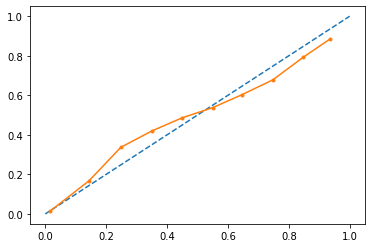

In [12]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
probs = xgb_res.predict_proba(X_test)[:,1]
fop, mpv = calibration_curve(Y_test, probs, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

По результатам - калибровка не нужна

## Вывод

По результатам работы была построена модель для определения тех людей, которые откроют депозит.